# Exercise 4 - Porting CuPy to NumPy code

This notebook contains a copy of the NumPy-based solution to Exercise 2.  In this exercise, you will port this code to run on CuPy.  Due to the similarity between CuPy and NumPy, there's very few changes to make:

1. Change `import numpy as xp` to `import cupy as xp`
2. NumPy arrays are converted to CuPy arrays using `xp.asarray()`.  You'll see errors like `only supports cupy.ndarray` when you have this problem.
3. CuPy arrays are converted back to NumPy arrays (for Matplotlib) using the `.get()` method on the array.

**Exercise: Port the SVD example to run on CuPy.**

In [1]:
import matplotlib.pyplot as plt
import cv2
import cupy as xp

Next let's download an image of Bryce's dog:

In [2]:
import urllib.request
urllib.request.urlretrieve(
    'https://drive.usercontent.google.com/download?id=1ClKrHt4-SIHaeBJdF0K3MG64jyVnt62L&export=download',
    'loonie.jpg')

('loonie.jpg', <http.client.HTTPMessage at 0x7fba83d4d010>)

Next we can read the image in grayscale mode:

In [6]:
image = cv2.imread('loonie.jpg', cv2.IMREAD_GRAYSCALE)
### MOVE IMAGE TO GPU

image = xp.asarray(image)

###
image.nbytes, image.shape, image

(1920000,
 (1600, 1200),
 array([[127, 128, 135, ...,  74,  70,  70],
        [128, 132, 135, ...,  78,  69,  72],
        [119, 127, 131, ...,  84,  75,  71],
        ...,
        [140, 133, 127, ..., 126, 139, 123],
        [144, 136, 129, ..., 130, 124, 115],
        [155, 145, 133, ..., 124, 114, 117]],
       shape=(1600, 1200), dtype=uint8))

Here we can see the image is 1600x1200 pixels, and each pixel is an unsigned 8-bit value (0-255).  Let's plot it with matplotlib to verify it looks correct:

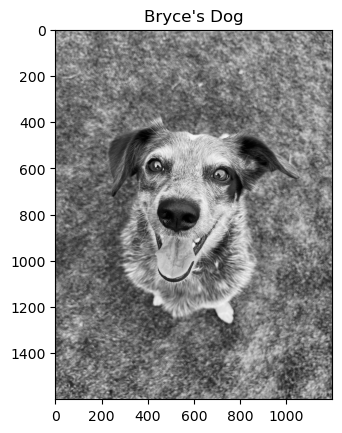

In [8]:
# Need to bring GPU image back to CPU with .get() to plot with matplotlib

plt.imshow(image.get(), cmap='gray')
plt.title("Bryce's Dog")
plt.show()

Yes, we can confirm that is a dog (and a very cute one at that).  Now let's start doing some linear algebra!

NumPy provides an [implementation of SVD](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html).  By selecting `full_matrices=False`, we get the singular value matrix, `S`, as a 1D vector rather than a 2D diagonal matrix.

In [9]:
U, S, Vt = xp.linalg.svd(image, full_matrices=False)
U.shape, S.shape, Vt.shape

((1600, 1200), (1200,), (1200, 1200))

Since the image is not square and we've not selected `full_matrices`, NumPy returns `U` as a non-square matrix, `S` as the 1D vector which is the smaller of the two dimensions, and the `Vt` matrix is a square matrix.

The signular values are returned in descending order, which we can see if we look at the first 10 elements of `S`:

In [10]:
S[:10]

array([168083.9407829 ,  23238.38484043,  19528.95172263,  15942.48480149,
        11745.41886782,  10402.5500467 ,   9557.42759704,   9301.19899873,
         8220.25409214,   8070.18502333])

In fact, if we look at the size of the singular values, we see that the first few contribute a lot to the matrix, and then fall off very rapidly:

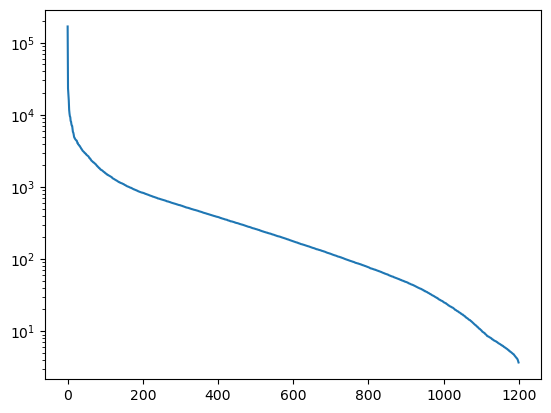

In [12]:
### COPY SINGULAR VALUE MATRIX BACK TO CPU
plt.semilogy(S.get())

That suggests we can get a pretty good approximation of the original image with a relatively small number of terms.  We can reconstruct the image matrix by slicing the `U`, `S`, and `Vt` matrices and remultiplying them.  We will need to convert `S` back into a 2D matrix for the multiplication as well.  Note that we are using the `@` operator to perform matrix multiplication, because `*` does element-wise multiplication.

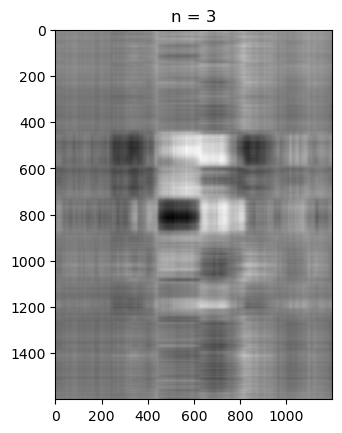

In [14]:
# First 3 terms
nterms = 3
reconstructed = U[:, :nterms] @ xp.diag(S[:nterms]) @ Vt[:nterms, :]
### COPY RECONSTRUCTED MATRIX BACK TO GPU
plt.imshow(reconstructed.get(), cmap='gray')
plt.title('n = 3')
plt.show()

That's still pretty fuzzy, so let's check out the image with more terms included:

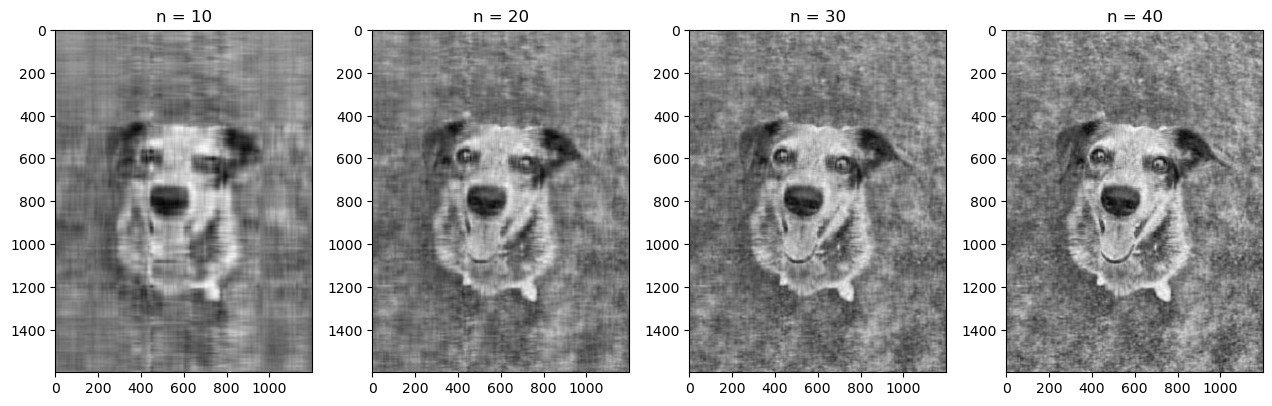

In [16]:
plt.figure(figsize=(16, 4))

start, end, step = 10, 50, 10
for i in range(start, end, step):
    plt.subplot(1, (end - start) // step + 1, (i - start) // step + 1)
    reconstructed = U[:, :i] @ xp.diag(S[:i]) @ Vt[:i, :]
    # COPY RECONSTRUCTED MATRIX BACK TO GPU
    plt.imshow(reconstructed.get(), cmap='gray')
    plt.title(f'n = {i}')

plt.tight_layout()
plt.show()

**Exercise: Print the compression ratio for the values of `n` used above.  This is the number of bytes of the reduced arrays added together and divided by the size of the original grayscale image array.  How does this compare to the size of the original color JPEG, which is 756473 bytes?  (Hint: `.nbytes` works on sliced arrays!)**

In [17]:
for i in range(start, end, step):
    compress_ratio = (U[:, :i].nbytes + S[:i].nbytes + Vt[:i, :].nbytes) / image.nbytes
    print(f'n = {i}: compression = {compress_ratio:.1%}')

n = 10: compression = 11.7%
n = 20: compression = 23.3%
n = 30: compression = 35.0%
n = 40: compression = 46.7%


**Exercise: Compute and display the difference in the reconstruction for n = 10 and the original image.  Use `cmap="coolwarm"` when you display the di image.**

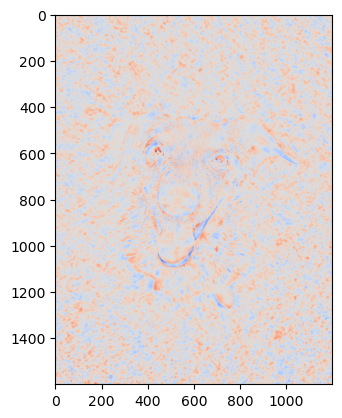

In [19]:
delta = image - (U[:,:10] @ xp.diag(S[:10]) @ Vt[:10,:])
### COPY DELTA MATRIX BACK TO GPU
plt.imshow(delta.get(), cmap='coolwarm')

Now that you have gotten SVD to work on CuPy, let's benchmark the speed.  To make things clearer, let's reimport NumPy and CuPy with their usual abbreviations:

In [20]:
import numpy as np
import cupy as cp

Now we can use the `%timeit` feature in Jupyter to measure how long a single statement takes.  Let's make sure we know which memory space our image is in and reload it into both CPU and GPU memory:

In [21]:
cpu_image = cv2.imread('loonie.jpg', cv2.IMREAD_GRAYSCALE)
gpu_image = cp.asarray(cpu_image)

Next let's benchmark both CPU and GPU execution:

In [22]:
print("CPU SVD")
%timeit np.linalg.svd(cpu_image, full_matrices=False)
print("GPU SVD")
%timeit cp.linalg.svd(gpu_image, full_matrices=False)

CPU SVD
560 ms ± 8.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
GPU SVD
571 ms ± 161 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Depending on your hardware, the CPU and GPU might be close to the same speed, or the GPU might even be slower!  This is because the image is not big enough to fully utilize the GPU.  We can simulate a larger image by tiling the image using `np.tile()`.  This duplicates the image both along axis 0 and axis 1:

In [27]:
cpu_image_tile = np.tile(cpu_image, (3,3))  ### CHANGE TO 3x3 tiling to see GPU significantly outperform CPU
gpu_image_tile = cp.asarray(cpu_image_tile)

Now we can benchmark again (this will take longer because the matrices are 4x bigger):

In [28]:
print("CPU SVD")
%timeit np.linalg.svd(cpu_image_tile, full_matrices=False)
print("GPU SVD")
%timeit cp.linalg.svd(gpu_image_tile, full_matrices=False)

CPU SVD
8.92 s ± 415 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
GPU SVD
4.66 s ± 14.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Exercise: Experiment with differ sizes of image by changing the np.tile arguments.  When is the GPU faster?**

In [29]:
cpu_image_tile.shape

(4800, 3600)